## Example notebook of supported datasets' initialization

In [1]:
import sys

sys.path.insert(0, "/home/igor.zubarev/projects/Disentangle")

In [2]:
import torch
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from disentangle.training import create_dataset, create_model
from disentangle.core.loss_type import LossType
from disentangle.config_utils import load_config
from disentangle.sampler.random_sampler import RandomSampler
from disentangle.analysis.lvae_utils import get_img_from_forward_output
from disentangle.analysis.plot_utils import clean_ax
from disentangle.core.data_type import DataType
from disentangle.core.psnr import PSNR
from disentangle.core.psnr import PSNR, RangeInvariantPsnr
from disentangle.core.data_split_type import DataSplitType
from disentangle.scripts.run import get_mean_std_dict_for_model

import ml_collections
import careamics

/localscratch/mamba/envs/splits/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/localscratch/mamba/envs/splits/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

In [4]:
fix_seeds()

In [5]:
ckpt_dir = "/group/jug/ashesh/training/disentangle/2408/D29-M3-S0-L8/24"
assert os.path.exists(ckpt_dir)

In [28]:
from disentangle.data_loader.patch_index_manager import TilingMode

image_size_for_grid_centers = 32
mmse_count = 1
custom_image_size = None
data_t_list = None #[0,1,2,3]
tiling_mode = TilingMode.ShiftBoundary

save_comparative_plots =False
enable_calibration = False
batch_size = 16
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Val 
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'

In [29]:
%run /home/igor.zubarev/projects/Disentangle/disentangle/notebooks/nb_core/config_loader.ipynb

data:
  channel_idx_list:
  - 0
  - 1
  channelwise_quantile: false
  clip_percentile: 1
  data_type: 29
  depth3D: 9
  deterministic_grid: false
  enable_gaussian_noise: false
  grid_size: 32
  image_size: 64
  input_has_dependant_noise: true
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  padding_mode: reflect
  padding_value: null
  poisson_noise_factor: -1
  randomized_channels: false
  sampler_type: 0
  synthetic_gaussian_scale: 228
  target_separate_normalization: true
  threshold: 0.02
  train_aug_rotate: false
  use_one_mu_std: true
  val_grid_size: 32
  zstart: 25
  zstop: 40
datadir: /group/jug/ashesh/data/Elisa3D/
exptname: 2408/D29-M3-S0-L8/24
git:
  branch: 3dtiling
  changedFiles: []
  latest_commit: 83b4dc28949f7b2a0775300362e65b4362d204c7
  untracked_files: []
hostname: gnode03
loss:
  denoisplit_w: 0.9
  free_bits: 1.0
  kl_annealing: false
  kl_annealtime: 10
  kl_loss_formulation: denoisplit_usplit
  kl_min: 1.0e-07
  kl_start: -1
  k

In [30]:
with config.unlocked():
    config.data.mode_3D = True

In [31]:
DATA_ROOT = '/group/jug/ashesh/data/'
CODE_ROOT = '/home/igor.zubarev/projects/Disentangle'

data_dir = "/localscratch/Elisa3D/"

padding_kwargs = {
    'mode':config.data.get('padding_mode','constant'),
}
dloader_kwargs = {'overlapping_padding_kwargs':padding_kwargs, 
                  'tiling_mode': tiling_mode,
                  }

In [32]:
train_dset_original, val_dset_original = create_dataset(config, data_dir, eval_datasplit_type=eval_datasplit_type,
                                      kwargs_dict=dloader_kwargs)


Loading from /localscratch/Elisa3D/20240725/WTC11_WT_DIV25_3_1_0001.nd2
ND2 dimensions: {'P': 16, 'Z': 69, 'C': 3, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
train_idx [ 2  1  9  0  8  5 12 10 15 11  4 13  3]

[MultiChDloader] Train:1 Sz:64227500 DimSz:(13,7,50,50,1) TrimB:2 Rot:False RandCrop:True Channel:2
Loading from /localscratch/Elisa3D/20240725/WTC11_WT_DIV25_3_1_0001.nd2
ND2 dimensions: {'P': 16, 'Z': 69, 'C': 3, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
val_idx [14  6]

[MultiChDloader] Train:0 Sz:6435000 DimSz:(2,7,50,50,1) TrimB:2 Rot:False RandCrop:False Channel:2


In [33]:
data_mean_original, data_std_original = train_dset_original.get_mean_std()

In [34]:
## Some simple visualization code
import matplotlib.pyplot as plt


def plot_sample(sample, is_3d=False):
    input, target = sample
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.axis('off')
    if not is_3d:
        plt.imshow(input[0])
    else:
        plt.imshow(input[0][0])

    plt.subplot(1, 3, 2)
    plt.title('Target 1')
    plt.axis('off')
    if not is_3d:
        plt.imshow(target[0])
    else:
        plt.imshow(target[0][0])

    plt.subplot(1, 3, 3)
    plt.title('Target 2')
    plt.axis('off')
    if not is_3d:
        plt.imshow(target[1])
    else:
        plt.imshow(target[1][0])
    
    plt.show()
    

def plot_sample_compare(sample1, sample2, is_3d=False):
    _, ax = plt.subplots(3, 2, figsize=(10, 25))
    input1, target1 = sample1
    input2, target2 = sample2
    
    ax[0, 0].set_title('Input 1')
    ax[0, 0].axis('off')
    if not is_3d:
        ax[0, 0].imshow(input1[0])
    else:
        ax[0, 0].imshow(input1[0][0])
    
    ax[0, 1].set_title('Input 2')
    ax[0, 1].axis('off')
    if not is_3d:
        ax[0, 1].imshow(input2[0])
    else:
        ax[0, 1].imshow(input2[0][0])
    
    ax[1, 0].set_title('Target 1/1')
    ax[1, 0].axis('off')
    if not is_3d:
        ax[1, 0].imshow(target1[0])
    else:
        ax[1, 0].imshow(target1[0][0])
    
    ax[1, 1].set_title('Target 1/2')
    ax[1, 1].axis('off')
    if not is_3d:
        ax[1, 1].imshow(target2[0])
    else:
        ax[1, 1].imshow(target2[0][0])
    
    ax[2, 0].set_title('Target 2/1')
    ax[2, 0].axis('off')
    if not is_3d:
        ax[2, 0].imshow(target1[1])
    else:
        ax[2, 0].imshow(target1[1][0])
    
    ax[2, 1].set_title('Target 2/2')
    ax[2, 1].axis('off')
    if not is_3d:
        ax[2, 1].imshow(target2[1])
    else:
        ax[2, 1].imshow(target2[1][0])
    plt.show()

# NicolaData

In [35]:
# from datasets import load_train_val_data_nikola, create_train_val_datasets
# from configs.nikolaData import get_data_configs

# train_data_config, val_data_config = get_data_configs()

# train_dset, val_dset, data_stats = create_train_val_datasets(
#     datapath='/group/jug/ashesh/data/nikola_data/20240531/',
#     train_config=train_data_config,
#     val_config=val_data_config,
#     load_data_func=load_train_val_data_nikola
# )

In [36]:
# for index in range(3):
#     sample = train_dset[index]
#     plot_sample(sample)

# Elisa3DData

In [37]:
from datasets import load_train_val_elisa3d, create_train_val_datasets
from configs.elisa3D import get_data_configs

train_data_config, val_data_config = get_data_configs()

In [38]:
# add config params

train_data_config.grid_size = 32
val_data_config.grid_size = 32


In [39]:
config.data

channel_idx_list:
- 0
- 1
channelwise_quantile: false
clip_percentile: 1
data_type: 29
depth3D: 9
deterministic_grid: false
enable_gaussian_noise: false
grid_size: 32
image_size: 64
input_has_dependant_noise: true
input_is_sum: false
mode_3D: true
multiscale_lowres_count: null
normalized_input: true
padding_mode: reflect
padding_value: null
poisson_noise_factor: -1
randomized_channels: false
sampler_type: 0
synthetic_gaussian_scale: 228
target_separate_normalization: true
threshold: 0.02
train_aug_rotate: false
use_one_mu_std: true
val_grid_size: 32
zstart: 25
zstop: 40

In [40]:
for i in train_data_config:
    print(i)

('data_type', <DataType.Elisa3DData: 0>)
('depth3D', 9)
('datasplit_type', <DataSplitType.Train: 1>)
('num_channels', 2)
('ch1_fname', None)
('ch2_fname', None)
('ch_input_fname', None)
('input_is_sum', False)
('input_idx', None)
('target_idx_list', None)
('start_alpha', None)
('end_alpha', None)
('image_size', 64)
('grid_size', 32)
('empty_patch_replacement_enabled', False)
('empty_patch_replacement_channel_idx', None)
('empty_patch_replacement_probab', None)
('empty_patch_max_val_threshold', None)
('uncorrelated_channels', False)
('uncorrelated_channel_probab', 0.5)
('poisson_noise_factor', -1.0)
('synthetic_gaussian_scale', 228.0)
('input_has_dependant_noise', True)
('enable_gaussian_noise', False)
('allow_generation', False)
('training_validtarget_fraction', None)
('deterministic_grid', None)
('enable_rotation_aug', False)
('max_val', None)
('overlapping_padding_kwargs', {'mode': 'reflect'})
('print_vars', False)
('normalized_input', True)
('use_one_mu_std', True)
('train_aug_rotat

In [41]:
for i in val_data_config:
    print(i)

('data_type', <DataType.Elisa3DData: 0>)
('depth3D', 9)
('datasplit_type', <DataSplitType.Val: 2>)
('num_channels', 2)
('ch1_fname', None)
('ch2_fname', None)
('ch_input_fname', None)
('input_is_sum', False)
('input_idx', None)
('target_idx_list', None)
('start_alpha', None)
('end_alpha', None)
('image_size', 64)
('grid_size', 32)
('empty_patch_replacement_enabled', False)
('empty_patch_replacement_channel_idx', None)
('empty_patch_replacement_probab', None)
('empty_patch_max_val_threshold', None)
('uncorrelated_channels', False)
('uncorrelated_channel_probab', 0.5)
('poisson_noise_factor', -1.0)
('synthetic_gaussian_scale', 228.0)
('input_has_dependant_noise', True)
('enable_gaussian_noise', False)
('allow_generation', False)
('training_validtarget_fraction', None)
('deterministic_grid', None)
('enable_rotation_aug', False)
('max_val', None)
('overlapping_padding_kwargs', {'mode': 'reflect'})
('print_vars', False)
('normalized_input', True)
('use_one_mu_std', True)
('train_aug_rotate'

In [42]:
train_dset, val_dset, data_stats = create_train_val_datasets(
    datapath=data_dir,
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=load_train_val_elisa3d
)

Loading from /localscratch/Elisa3D/20240725/WTC11_WT_DIV25_3_1_0001.nd2
ND2 dimensions: {'P': 16, 'Z': 69, 'C': 3, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
train_idx [ 2  1  9  0  8  5 12 10 15 11  4 13  3]

Padding is not used with this alignement style
Loading from /localscratch/Elisa3D/20240725/WTC11_WT_DIV25_3_1_0001.nd2
ND2 dimensions: {'P': 16, 'Z': 69, 'C': 3, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
val_idx [14  6]

Padding is not used with this alignement style


In [43]:
train_dset.idx_manager, train_dset_original.idx_manager

(GridIndexManager(data_shape=(13, 15, 1608, 1608, 2), grid_shape=(1, 1, 32, 32, 2), patch_shape=(1, 9, 64, 64, 2), tiling_mode=<TilingMode.ShiftBoundary: 2>),
 GridIndexManager(data_shape=(13, 15, 1608, 1608, 2), grid_shape=(1, 1, 32, 32, 2), patch_shape=(1, 9, 64, 64, 2), tiling_mode=2))

In [44]:
val_dset.idx_manager, val_dset_original.idx_manager

(GridIndexManager(data_shape=(2, 15, 1608, 1608, 2), grid_shape=(1, 1, 32, 32, 2), patch_shape=(1, 9, 64, 64, 2), tiling_mode=<TilingMode.ShiftBoundary: 2>),
 GridIndexManager(data_shape=(2, 15, 1608, 1608, 2), grid_shape=(1, 1, 32, 32, 2), patch_shape=(1, 9, 64, 64, 2), tiling_mode=2))

In [45]:
val_dset._data.shape, val_dset_original._data.shape

((2, 15, 1608, 1608, 2), (2, 15, 1608, 1608, 2))

In [47]:
len(train_dset), len(train_dset_original), len(val_dset), len(val_dset_original)

(227500, 227500, 35000, 35000)

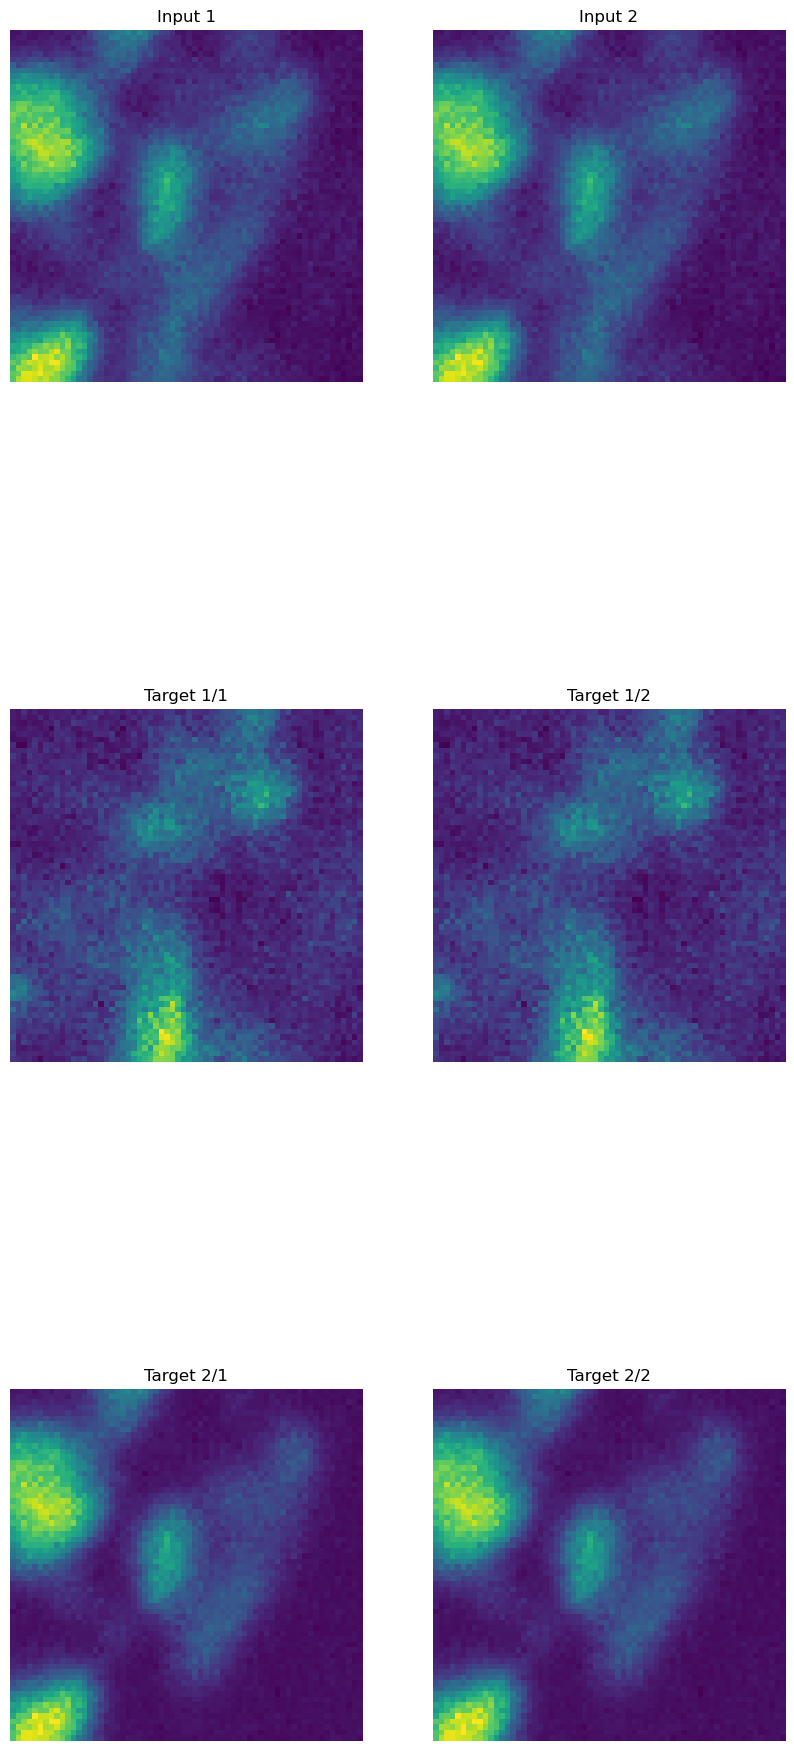

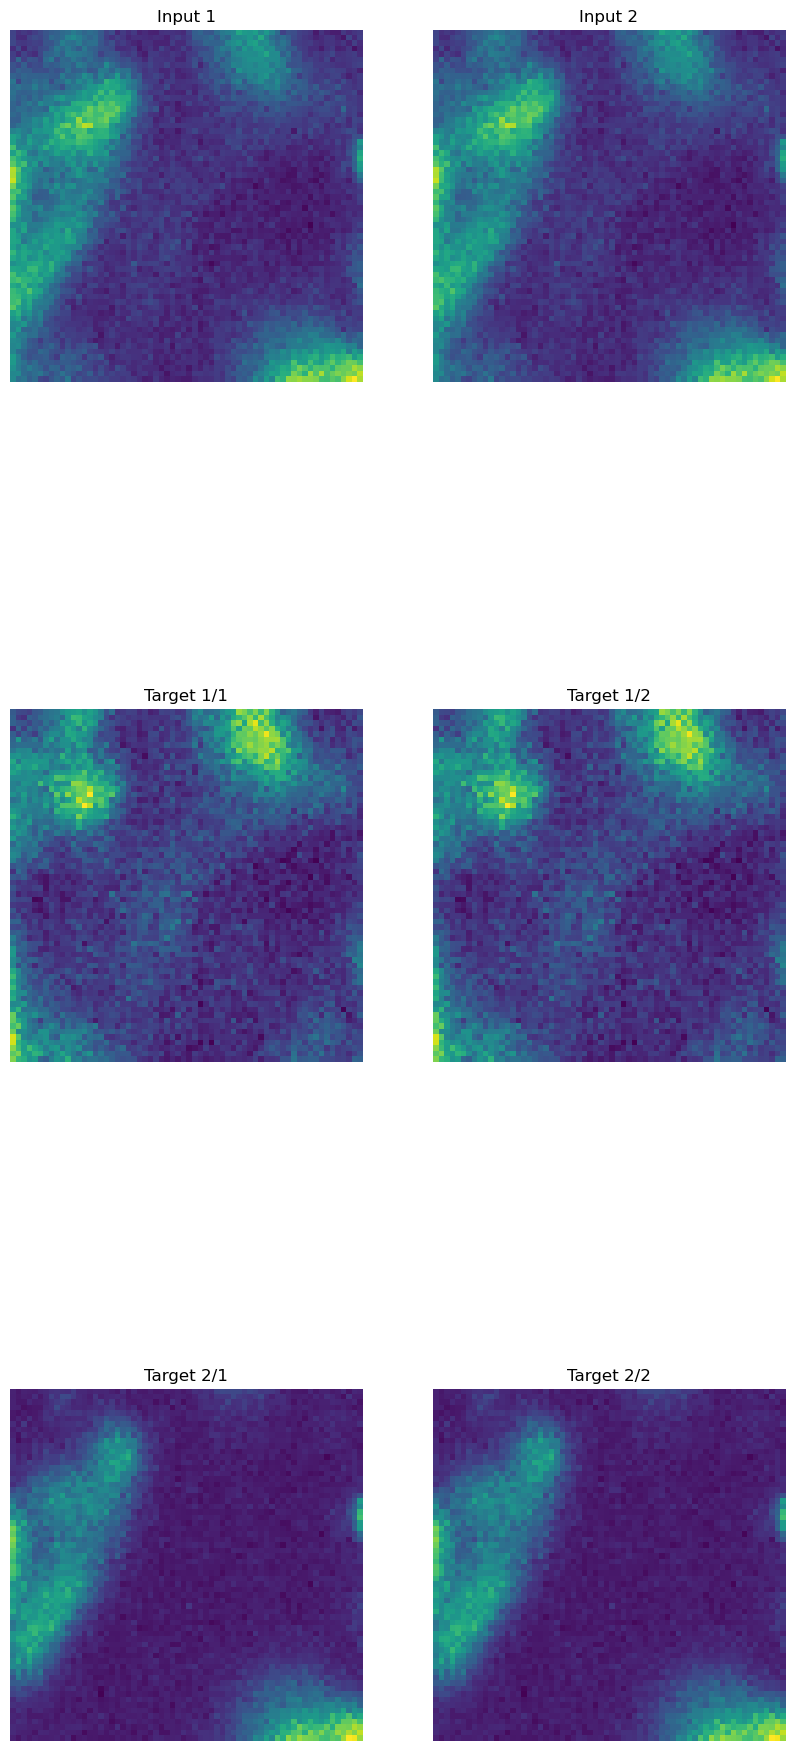

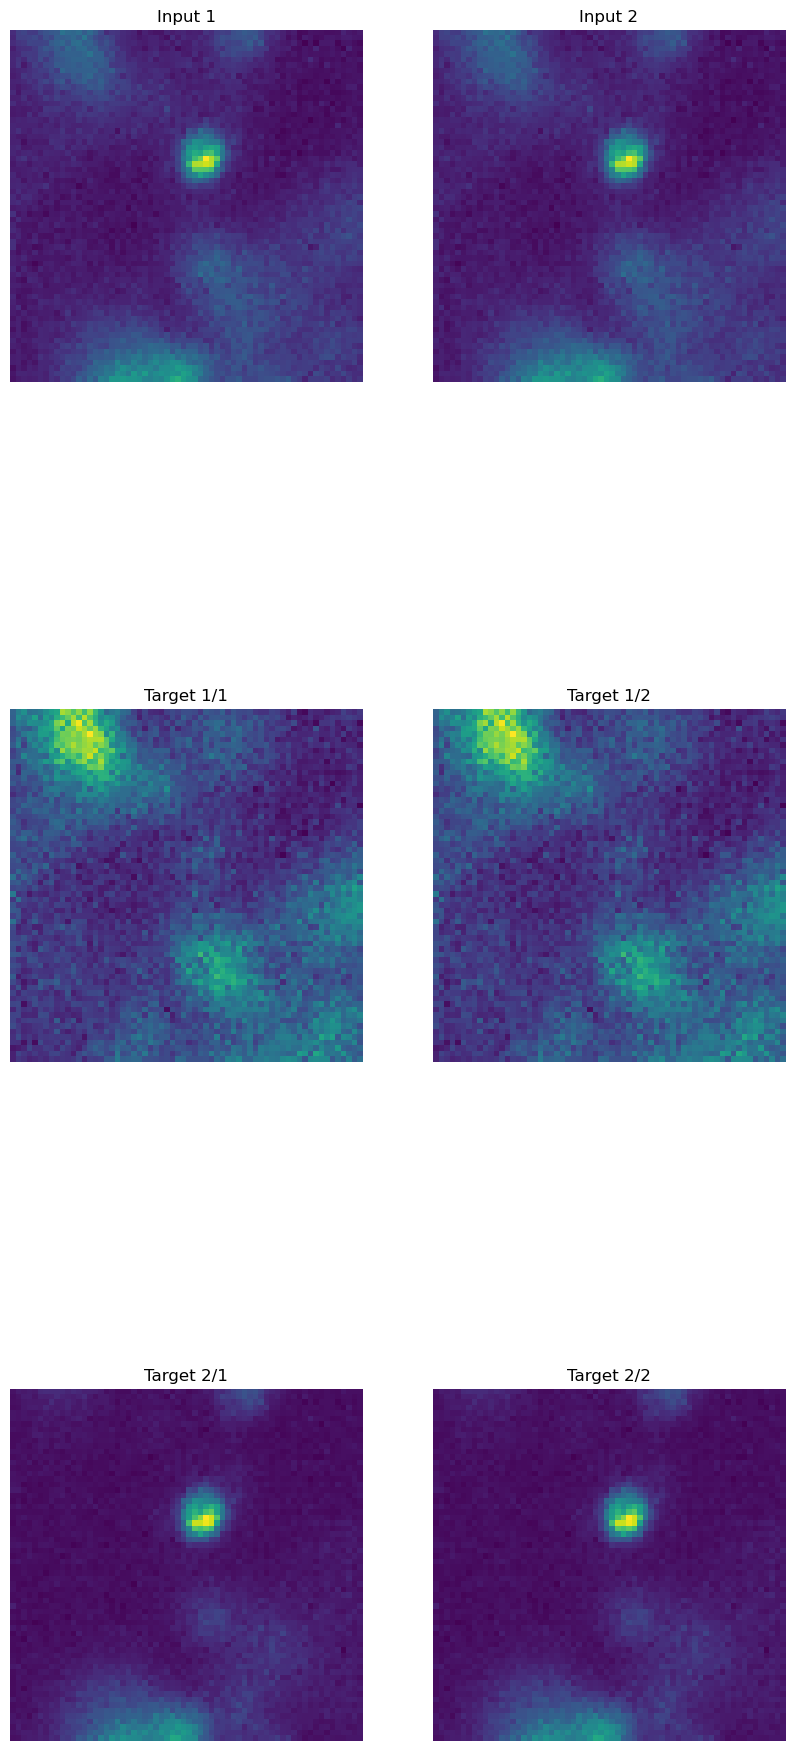

In [70]:
for index in range(1000, 1003):
    sample = val_dset[index]
    sample_old = val_dset_original[index]
    plot_sample_compare(sample, sample_old, is_3d=True)



In [65]:
sample[0].min(), sample[0].max(), sample[0].mean(), sample[0].std()


(-0.83336455, -0.46102428, -0.67669773, 0.03132265)

In [66]:
sample_old[0].min(), sample_old[0].max(), sample_old[0].mean(), sample_old[0].std()

(-0.83336455, -0.46102428, -0.67669773, 0.03132265)

# Pavia3SeqData

In [ ]:
from datasets import load_train_val_pavia3, create_train_val_datasets
from configs.pavia3 import get_data_configs

train_data_config, val_data_config = get_data_configs()

train_dset, val_dset, data_stats = create_train_val_datasets(
    datapath='/group/jug/ashesh/data/pavia3_sequential_cropped/',
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=load_train_val_pavia3
)

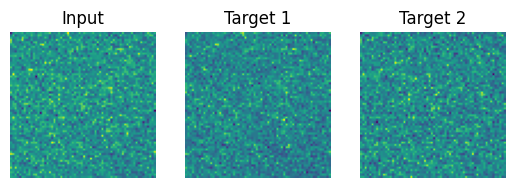

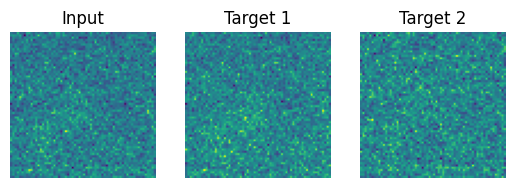

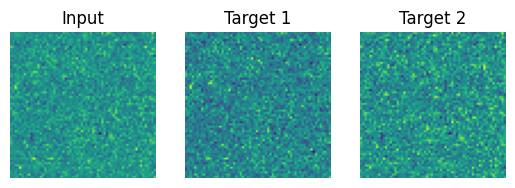

In [7]:
for index in range(3):
    sample = train_dset[index]
    plot_sample(sample, is_3d=False)

# TavernaSox2Golgi

In [ ]:
from datasets import load_train_val_sox2golgi, create_train_val_datasets
from configs.sox2golgi import get_data_configs

train_data_config, val_data_config = get_data_configs()

train_dset, val_dset, data_stats = create_train_val_datasets(
    datapath='/group/jug/ashesh/data/TavernaSox2Golgi/',
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=load_train_val_sox2golgi
)

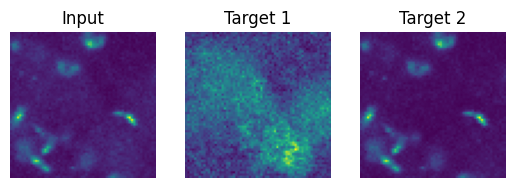

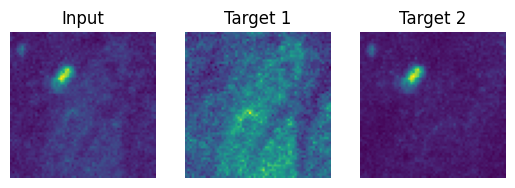

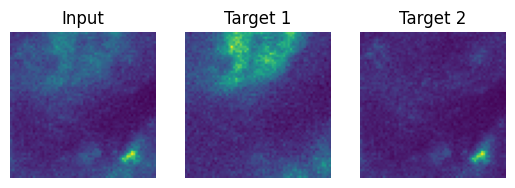

In [9]:
for index in range(3):
    sample = train_dset[index]
    plot_sample(sample, is_3d=False)

# TavernaSox2GolgiV2

In [ ]:
from datasets import load_train_val_sox2golgi_v2, create_train_val_datasets
from configs.sox2golgi_v2 import get_data_configs

train_data_config, val_data_config = get_data_configs()

train_dset, val_dset, data_stats = create_train_val_datasets(
    datapath='/group/jug/ashesh/data/TavernaSox2Golgi/acquisition2/',
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=load_train_val_sox2golgi_v2
)

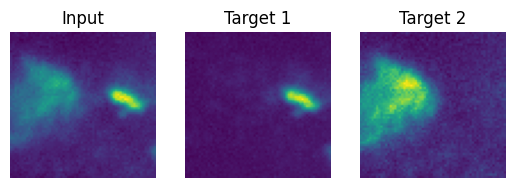

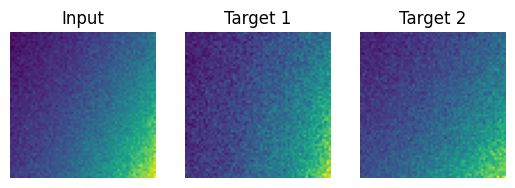

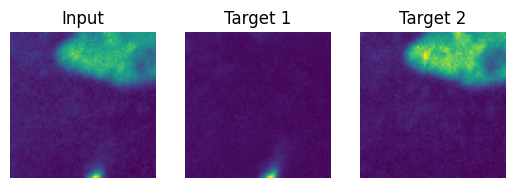

In [11]:
for index in range(3):
    sample = train_dset[index]
    plot_sample(sample, is_3d=False)

# ExpMicroscopyV1

In [ ]:
from datasets import load_train_val_exp_microscopy, create_train_val_datasets
from configs.exp_microscopy_v1 import get_data_configs

train_data_config, val_data_config = get_data_configs()

train_dset, val_dset, data_stats = create_train_val_datasets(
    datapath='/group/jug/ashesh/data/expansion_microscopy_v1/MDCK_MitoDeepRed639_AlphaBetaTub488/',
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=load_train_val_exp_microscopy
)

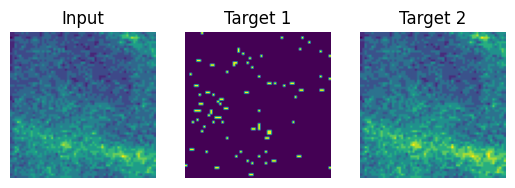

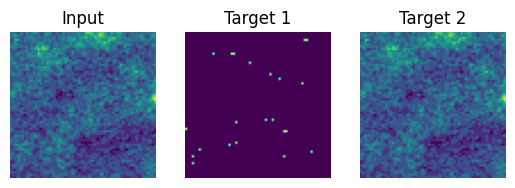

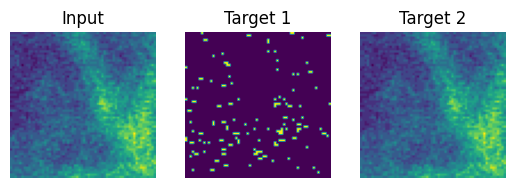

In [13]:
for index in range(3):
    sample = train_dset[index]
    plot_sample(sample, is_3d=False)

# ExpMicroscopyV2

In [ ]:
from datasets import load_train_val_exp_microscopy, create_train_val_datasets
from configs.exp_microscopy_v2 import get_data_configs

train_data_config, val_data_config = get_data_configs()


train_dset, val_dset, data_stats = create_train_val_datasets(
    datapath='/group/jug/ashesh/data/expansion_microscopy_v2/datafiles/',
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=load_train_val_exp_microscopy
)

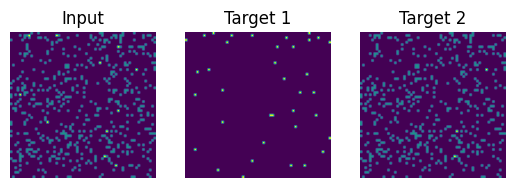

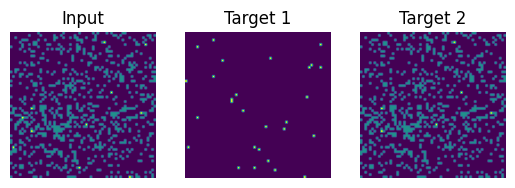

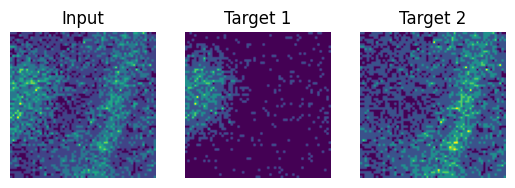

In [15]:
for index in range(3):
    sample = train_dset[index]
    plot_sample(sample, is_3d=False)

## Dao3Ch

In [ ]:
from datasets import load_train_val_dao_3ch, create_train_val_datasets
from configs.dao3ch import get_data_configs

train_data_config, val_data_config = get_data_configs()


train_dset, val_dset, data_stats = create_train_val_datasets(
    datapath='/group/jug/ashesh/data/Dao3Channel/',
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=load_train_val_dao_3ch
)

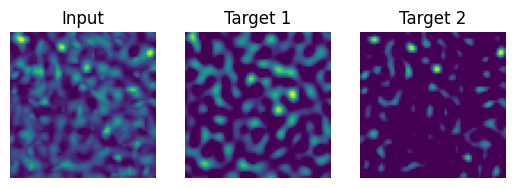

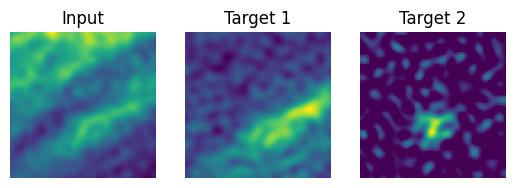

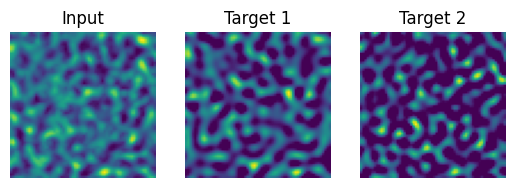

In [3]:
for index in range(3):
    sample = train_dset[index]
    plot_sample(sample, is_3d=False)

## Dao3ChWithInput

In [ ]:
from datasets import load_train_val_dao_3ch, create_train_val_datasets
from configs.dao3chWithInput import get_data_configs

train_data_config, val_data_config = get_data_configs()


train_dset, val_dset, data_stats = create_train_val_datasets(
    datapath='/group/jug/ashesh/data/Dao4Channel/',
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=load_train_val_dao_3ch
)

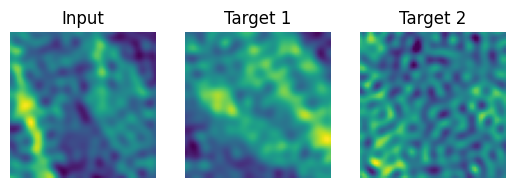

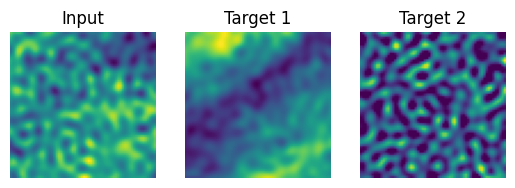

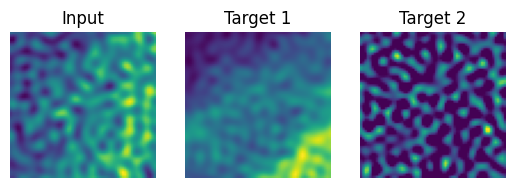

In [3]:
for index in range(3):
    sample = train_dset[index]
    plot_sample(sample, is_3d=False)

## HTIba1Ki67

In [ ]:
from datasets import load_iba1_ki67_files, create_train_val_datasets
from configs.ht_iba1_ki64_config import get_data_configs

train_data_config, val_data_config = get_data_configs()


train_dset, val_dset, data_stats = create_train_val_datasets(
    datapath='/group/jug/ashesh/data/Stefania/20240730_Ki67_and_Iba1_trainingdata/',
    train_config=train_data_config,
    val_config=val_data_config,
    load_data_func=load_iba1_ki67_files
)

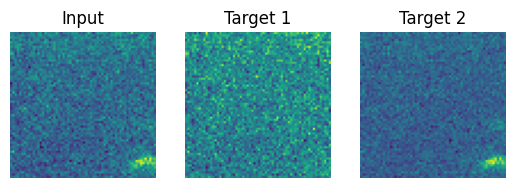

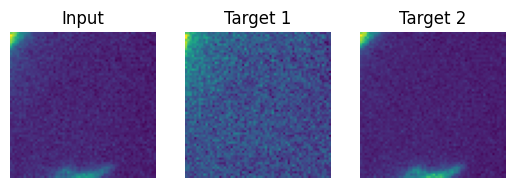

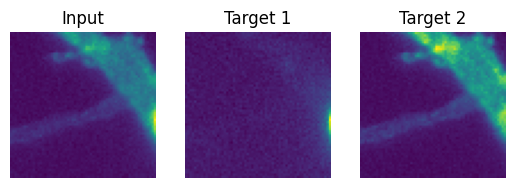

In [4]:
for index in range(3):
    sample = train_dset[index]
    plot_sample(sample, is_3d=False)